<a href="https://colab.research.google.com/github/jawnpaul/Mlmodels/blob/master/Copy_of_newer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import numpy as np
from numpy import genfromtxt

import tensorflow as tf
from tensorflow import keras
import datetime as dt

from tensorflow.contrib import lite

my_data = genfromtxt('WMT.csv', delimiter=',')



#Ignore the first row 
my_data = (my_data[1:])
#print(my_data.shape)

#Ignore the first column
my_data = (my_data[:,1:])
#print(my_data.shape)

#From 20 to the end
train_data = (my_data[20:])
#print(train_data.shape)
#print(train_data)


#From beginning to 20
test_data = (my_data[:20])
#print(test_data.shape)
#print(test_data)

#Get the price column
#price_data = my_data[:,3]
#print(price_data)

#THe labels are the prices
train_labels = train_data[:,3]

test_labels = test_data[:,3]



# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

#this deletes the price column
#my_data = np.delete(my_data, 3, 1)
#print(my_data)
dd = list(train_data[0])
print(len(dd))

5


In [158]:
print("Training set: {}".format(train_data.shape))  # 70 examples, 5 features
print("Testing set:  {}".format(test_data.shape))   # 30 examples, 5 features

Training set: (80, 5)
Testing set:  (20, 5)


In [159]:
import pandas as pd
column_names = ['OPEN', 'HIGH', 'LOW','PRICE', 'VOLUME']

df = pd.DataFrame(train_data, columns=column_names)
df.head()
#36.53,37.49,36.36,37.06,152078800.0

,OPEN,HIGH,LOW,PRICE,VOLUME
0,92.67,93.39,92.25,93.15,7006026.0
1,91.22,92.01,90.16,90.77,9001756.0
2,97.59,97.87,96.53,97.13,8054324.0
3,86.42,90.42,86.30,90.41,10028292.0
4,95.25,95.94,95.02,95.60,6099857.0


In [160]:
print(train_labels[0:10])  # Display first 10 entries

[93.15 90.77 97.13 90.41 95.6  90.55 98.69 99.03 96.97 87.28]


In [161]:
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std




print(train_data[0])  # First training sample, normalized
print(train_labels.shape)

[-1.05146933 -1.16455299 -0.94533353 -0.94889191 -0.32441428]
(80,)


In [162]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  #optimizer = tf.train.RMSPropOptimizer(0.001).
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

print(train_data.shape[1],)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
5


In [163]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

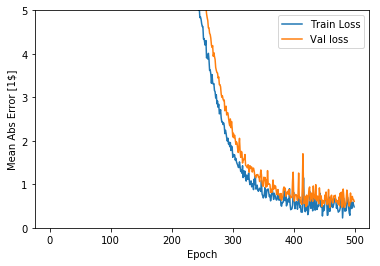

In [164]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)


....................................................................................................
....................................................................................................
....................................................................

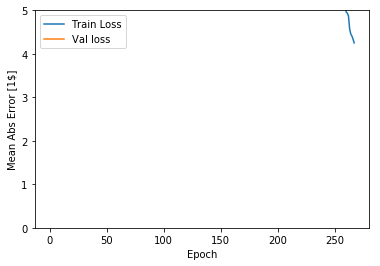

In [165]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [166]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1))

Testing set Mean Abs Error: $  17.91


(1, 5)
[96.13313]
20/20 [==============================] - 0s 45us/sample - loss: 390.8610 - mean_absolute_error: 17.9053
Test accuracy this is still actually my mae: 17.905323


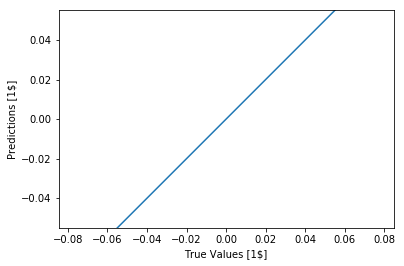

In [167]:
#test_predictions = model.predict(test_data[[1]]).flatten()


data = np.array([[-0.1037204,-0.14475672,-0.2594339,-0.0976705064,-0.6376169]])
print(data.shape)
test_predictions = model.predict(data).flatten()
#plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1$]')
plt.ylabel('Predictions [1$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])
#print(test_data[[0]])
print(test_predictions)
test_loss, test_acc = model.evaluate(test_data, test_labels)


#print(test_data.all)
print('Test accuracy this is still actually my mae:', test_acc)

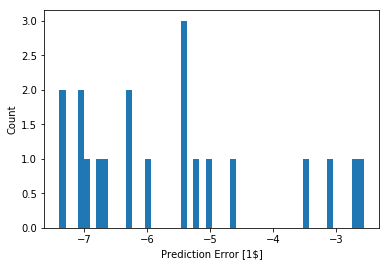

In [168]:
error = test_predictions - test_labels
#print(error)
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1$]")
_ = plt.ylabel("Count")



In [0]:
from tensorflow.contrib import lite

keras_file = "model.h5"
keras.models.save_model(model, keras_file)

In [170]:
converter = lite.TFLiteConverter.from_keras_model_file( 'model.h5' ) 
model = converter.convert()

file = open( 'WMTmodel.tflite' , 'wb' ) 
file.write( model )

INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.


19656

In [0]:
from google.colab import files


#converter = lite.TocoConverter.from_keras_model_file(keras_file)

#tflite_model = converter.convert()
#open("model_.tflite", "wb").write(tflite_model)

files.download('WMTmodel.tflite')
